# QuantumSim - 3-Qubit Adder
Author: Nico Kuijpers <br>
Date: January 26, 2025

In this notebook, a quantum circuit for a $3$-qubit adder is described and tested for all possible combinations
of $3$-bit numbers $a$ and $b$ ($0 \leq a,b \leq 7$). Although QuantumSim is used in this notebook,
the code can be readily converted to Qiskit.

The $3$-qubit adder is adapted from Chapter 9 of:<br>
Robert S. Sutor, *Dancing with Qubits: From qubits to algorithms, embark on the quantum computing journey shaping our future*,
second edition, Packt Publishing, Birmingham, UK, ISBN 978-1-83763-675-4

In [1]:
from quantumsim import *

## Introduction

As classical computers are very good at arithmetic, it does not seem efficient to implement a calculator of some sort in quantum computing.
However, in some cases it can be helpful to include arithmetic as part a quantum algorithm!

In this notebook we will show how a circuit can be designed to compute the sum of two $3$-bit numbers $a$ and $b$.
This circuit can then be used as a part of a Grover oracle to find all possible combinations of $3$-bit numbers
$a$ and $b$ for which it holds $a + b = S$, $0 \leq S \leq 14$.

The $3$-qubit adder is used as part of a Grover oracle in this notebook from QuantumSim:

https://github.com/nicokuijpers/QuantumSim/blob/main/QuantumSimThreeQubitAdderGrover.ipynb

## Addition
Suppose qubit $q_0$ is in state $|x\rangle$ and qubit $q_1$ is in state $|y\rangle$,
then the circuit below can be used to bring qubit $q_1$ in state $|x\rangle \oplus |y\rangle$.
Here, "$\oplus$" means addition modulo $2$. The CNOT implements an exlusive OR (XOR).

```markdown
q0: |x⟩ ─────●─────|x⟩
             │
q1: |y⟩ ─────X─────|x⟩⊕|y⟩
```

The next step is to determine the carry-out state. In case $|x\rangle = |y\rangle = |1\rangle$, then the carry-out state $|c_{\text{out}}\rangle = |1\rangle$, otherwise
$|c_{\text{out}}\rangle = |0\rangle$. To accomplish this, a third qubit $q_3$ is added that will get the state of the carry-out 
$|c_{\text{out}}\rangle = |x\rangle \cdot |y\rangle$ (the logical AND gate) by applying a Toffoli gate
with control qubits $q_0$ and $q_1$, and target qubit $q_2$. The initial state of $q_2$ should be $|0\rangle$.


```markdown
q0: |x⟩ ─────●────●─────|x⟩
             │    │
q1: |y⟩ ─────●────X─────|x⟩⊕|y⟩
             │
q2: |0⟩ ─────X──────────|cout⟩ = |x⟩·|y⟩
```

### Carry gate
The circuit above can be extended to a Carry gate by including a carry-in state $|c_{\text{in}}\rangle$. 
The carry-in state will be the initial state of qubit $q_0$ and the qubits will be rearranged.

```markdown
q0: |cin⟩ ───────────────●─────|cin⟩
                         │
q1: |x⟩   ─────●────●────┼─────|x⟩
               │    │    │
q2: |y⟩   ─────●────X────●─────|x⟩⊕|y⟩
               │         │
q3: |0⟩   ─────X─────────X─────|cout⟩
```

The state $|c_{\text{out}}\rangle$ is the carry-out defined by

$|c_{\text{out}}\rangle = |x\rangle \cdot |y\rangle + |c_{\text{cin}}\rangle \cdot (|x\rangle \oplus |y\rangle)$.

Below, python function *carry()* is defined to extend a quantum circuit with a Carry gate.


In [2]:
def carry(circuit:Circuit, carry_in:int, x:int, y:int, carry_out:int):
    """
    Extends a quantum circuit with a Carry gate. 
    A Carry gate determines the sum of the carry-in bit and bit values x and y.
    The resulting sum will be stored in the qubit containing the y bit.
    The carry-out will be stored in the carry-out bit.

    Parameters:
    circuit (Circuit) : The quantum circuit to be extended
    carry_in (int)    : The qubit containing the carry-in state
    x (int)           : The qubit containing the bit value x
    y (int)           : The qubit containing the bit value y, here the sum x + y (mod 2) will be stored
    carry_out (int)   : The qubit to store the carry-out state. Should be |0>.

    Returns:
    None
    """
    circuit.toffoli(x, y, carry_out)
    circuit.cnot(x, y)
    circuit.toffoli(carry_in, y, carry_out)

### Inverse Carry Gate
In order to create a $3$-qubit adder, we will also need the inversed version of the Carry gate.
Below, python function *carry_inverse()* is defined to extend a quantum circuit with the inverse of the Carry gate introduced above.

In [3]:
def carry_inverse(circuit:Circuit, carry_in:int, x:int, y:int, carry_out:int):
    """
    Extends a quantum circuit with an inversed version of the Carry gate. 
    A Carry gate determines the sum of the carry-in bit and bit values x and y.
    The resulting sum will be placed in the qubit containing the y bit.
    The carry-out will be stored in the carry-out bit.

    Parameters:
    circuit (Circuit) : The quantum circuit to be extended
    carry_in (int)    : The qubit containing the carry-in state
    x (int)           : The qubit containing the bit value x
    y (int)           : The qubit containing the bit value y, here the sum x + y (mod 2) will be stored
    carry_out (int)   : The qubit to store the carry-out state. Should be |0>.

    Returns:
    None
    """
    circuit.toffoli(carry_in, y, carry_out)
    circuit.cnot(x, y)
    circuit.toffoli(x, y, carry_out)
   

### Sum Gate
Finally, we need a Sum gate to add two bit values and store the result. The two inputs $|x\rangle$ and $|y\rangle$ are added to
the state of the third qubit using two CNOT gates.

```markdown
q0: |x⟩ ──────────●─────|x⟩
                  │
q1: |y⟩ ─────●────┼─────|y⟩
             │    │
q2: |s⟩ ─────X────X─────|s⟩⊕|x⟩⊕|y⟩
```

Below, python function *sum()* is defined to extend a quantum circuit with a Sum gate.


In [4]:
def sum(circuit:Circuit, x:int, y:int, out:int):
    """
    Extends a quantum circuit with a Sum gate. 
    A Sum gate adds bit values x and y to the state of the third qubit.
    |out> --> |out> + |x> + |y> (mod 2)

    Parameters:
    circuit (Circuit) : The quantum circuit to be extended
    x (int)           : The qubit containing the bit value x
    y (int)           : The qubit containing the bit value y
    out (int)         : The qubit to which bit values x and y are added. 

    Returns:
    None
    """
    circuit.cnot(x, out)
    circuit.cnot(y, out)

## 3-Qubit Adder
Using the Carry gate, inverse Carry gate, Sum gate, and a CNOT gate, a $3$-qubit adder can be constructed as follows:

```markdown
            ┌─────────┐                                                                                ┌─────────┐    ┌───────┐  
q0: |0⟩  ───│         │────────────────────────────────────────────────────────────────────────────────│         │────│       │───|0⟩
            │         │                                                                                │         │    │       │ 
q1: |x0⟩ ───┤  Carry  ├────────────────────────────────────────────────────────────────────────────────┤  Carry  ├────┤  Sum  ├───|x0⟩
            │         │                                                                                │ inverse │    │       │  
q2: |y0⟩ ───┤         ├────────────────────────────────────────────────────────────────────────────────┤         ├────┤       ├───|z0⟩
            │         │    ┌─────────┐                                     ┌─────────┐    ┌───────┐    │         │    └───────┘  
q3: |0⟩  ───┤         ├────│         │─────────────────────────────────────│         │────│       │────┤         ├────────────────|0⟩
            └─────────┘    │         │                                     │         │    │       │    └─────────┘ 
q4: |x1⟩ ──────────────────┤  Carry  ├─────────────────────────────────────┤  Carry  ├────┤  Sum  ├───────────────────────────────|x1⟩
                           │         │                                     │ inverse │    │       │        
q5: |y1⟩ ──────────────────┤         ├─────────────────────────────────────┤         ├────┤       ├───────────────────────────────|z1⟩
                           │         │    ┌─────────┐         ┌───────┐    │         │    └───────┘ 
q6: |0⟩  ──────────────────┤         ├────│         │─────────│       │────┤         ├────────────────────────────────────────────|0⟩
                           └─────────┘    │         │         │       │    └─────────┘  
q7: |x2⟩ ─────────────────────────────────┤  Carry  ├────●────┤  Sum  ├───────────────────────────────────────────────────────────|x2⟩
                                          │         │    │    │       │   
q8: |y2⟩ ─────────────────────────────────┤         ├────X────┤       ├───────────────────────────────────────────────────────────|z2⟩
                                          │         │         └───────┘
q9: |0⟩  ─────────────────────────────────┤         ├─────────────────────────────────────────────────────────────────────────────|z3⟩
                                          └─────────┘
```
 In this circuit, $x_0$ and $y_0$ represent the *least* significant bits and $x_2$ and $y_2$ the *most* significant bits of input
 values $x$ and $y$. The sum $z = x + y$ will be stored in qubits $q_2$, $q_5$, $q_8$, and $q_9$ from least significant bit $z_0$ to most
 significant bit $z_3$.

 Below, python function *three_qubit_adder()* is defined to extend a quantum circuit with a $3$-qubit adder. Calls are made to functions *carry()*, *carry_inverse()*, 
 and *sum()* defined above.

In [5]:
def three_qubit_adder(circuit:Circuit):
    """
    Extends a quantum circuit with a 3-qubit adder.
    Input x = x0 x1 x2 is the state of qubits q1, q4, q7 (least significant --> most significant)
    Input y = y0 y1 y2 is the state of qubits q2, q5, q8 (least significant --> most significant)
    Output z = x + y = z0 z1 z2 z3 will be the state of q2, q5, q8, q9 (least significant --> most significant)

    Parameters:
    circuit (Circuit) : The quantum circuit to be extended

    Returns:
    None
    """
    # Consistency check: number of qubits mus be at least 10
    if circuit.N < 10:
        raise ValueError("At least 10 qubits are needed for 3-qubit adder")
    
    # Create a 3-qubit adder by extending the circuit with
    # Carry gates, inverse Carry gates, Sum gates, and a CNOT gate
    carry(circuit, 0, 1, 2, 3)
    carry(circuit, 3, 4, 5, 6)
    carry(circuit, 6, 7, 8, 9)
    circuit.cnot(7, 8)
    sum(circuit, 6, 7, 8)
    carry_inverse(circuit, 3, 4, 5, 6)
    sum(circuit, 3, 4 ,5)
    carry_inverse(circuit, 0, 1, 2, 3)
    sum(circuit, 0, 1, 2)

Using the python function *three_qubit_adder()* defined above, a quantum circuit can be created to compute the sum of 
integer values $x$ and $y$, $0 \leq x,y \leq 7$.
The function has as input the $3$-bit representations $x_0 x_1 x_2$ and $y_0 y_1 y_2$, where 
$x_0$ and $y_0$ represent the *least* significant bits and $x_2$ and $y_2$ the *most* significant bits.

Below, python function *create_three_qubit_adder_circuit()* is defined to create a quantum circuit to compute the sum of $x$ and $y$ 
represented by $x_0 x_1 x_2$ and $y_0 y_1 y_2$.

In [6]:
def create_three_qubit_adder_circuit(x0:int, x1:int, x2:int, y0:int, y1:int, y2:int):
    """
    Creates a quantum circuit with a 3-qubit adder.
    Input x = x0 x1 x2 will be the initial state of qubits q1, q4, q7 (least significant --> most significant)
    Input y = y0 y1 y2 will be the initial state of qubits q2, q5, q8 (least significant --> most significant)
    Output z = x + y = z0 z1 z2 z3 can be obtained by measuring the states of q2, q5, q8, q9 (least significant --> most significant)

    Parameters:
    x0, x1, x2 (int): 3-bit representation of input x (least significant --> most significant)
    y0, y1, y2 (int): 3-bit representation of input y (least significant --> most significant)

    Returns:
    Circuit to compute the sum of x and y
    """
    circuit = Circuit(10)
    if x0 == 1:
        circuit.pauli_x(1)
    if x1 == 1:
        circuit.pauli_x(4)
    if x2 == 1:
        circuit.pauli_x(7)
    if y0 == 1:
        circuit.pauli_x(2)
    if y1 == 1:
        circuit.pauli_x(5)
    if y2 == 1:
        circuit.pauli_x(8)
    three_qubit_adder(circuit)
    return(circuit)

## Example: 2 + 3 = 5
Below a circuit is created to compute the sum $z=x+y$ with $x=2$ and $y=3$. Keeping in mind that $x_0$ and $y_0$ are the least significant
bits, input value $x=2$ is established by setting parameters $x_0 = 0$, $x_1 = 1$, and $x_2 = 0$, 
and input value $y=3$ is established by setting $y_0 = 1$, $y_1 = 1$, and $y_2 = 0$.

The result should be $z=5$, which is represented by the $4$-bit string $1010$ (least significant bit first). 
After executing and measuring the qubits, the states of qubits $q_2$, $q_5$, $q_8$, and $q_9$ should represent this bit string.
Qubits $q_1$, $q_4$, and $q_7$ should be in their initial states representing input value $x$. The remaining qubits should be 
in state $|0\rangle$. Overall, the circuit should be in state $|0010100010\rangle$.

Below the circuit is created and then executed and measured. A histogram is created to show the measured classical states.

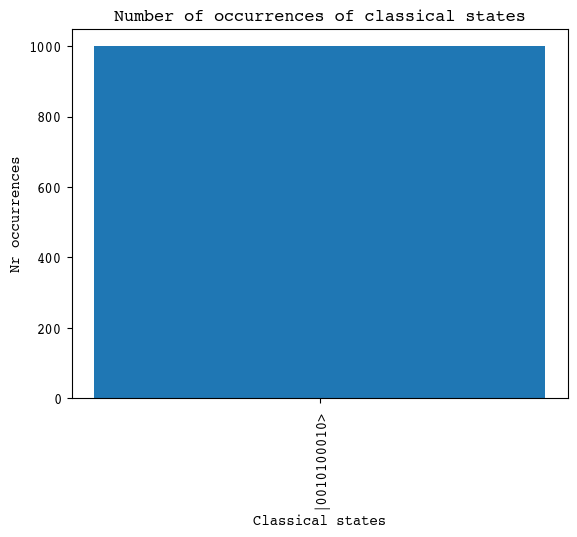

In [7]:
circuit = create_three_qubit_adder_circuit(x0=0, x1=1, x2=0, y0=1, y1=1, y2=0)
result = QuantumUtil.measure_circuit(circuit, 1000)
QuantumUtil.histogram_of_classical_states(result)

As expected, the only state that is measured is $|0010100010\rangle$. Below, the circuit gates are printed. The first three lines are Pauli X gates
applied to qubits $q_4$, $q_2$, and $q_5$ to set $x_1 = 1$, $y_0 = 1$, and $y_1 = 1$. The next three groups of three lines represent the Carry gates, etc.
Do you recognize the $3$-qubit adder?

In [8]:
circuit.print_gates()

....X.....
..X.......
.....X....
.**X......
.*X.......
*.*X......
....**X...
....*X....
...*.*X...
.......**X
.......*X.
......*.*X
.......*X.
......*.X.
.......*X.
...*.*X...
....*X....
....**X...
...*.X....
....*X....
*.*X......
.*X.......
.**X......
*.X.......
.*X.......


## Addition
Below, functions are defined to support both classical and quantum addition. 

Function *add_classical()* computes the sum of two integer values $a$ and $b$, $0 \leq a,b \leq 7$.

In [9]:
def add_classical(a:int, b:int) -> int:
    """
    Computes the sum of two integer values using classical addition.

    Parameters:
    a, b (int): Input integer values, 0 <= a, b <= 7

    Returns:
    a + b
    """
    if a < 0 or a > 7 or b < 0 or b > 7:
        raise ValueError(f"Input parameters {a} and {b} not valid")
    return a + b

Function *convert_to_binary_lsb()* converts an integer value to an array of bits of given length with least significant bit first.

In [10]:
def convert_to_binary_lsb(value:int, nr_bits:int):
    """
    Converts an integer value to a bit array of given length with least significant bit first.

    Parameters:
    value (int)   : Integer value to be converted
    nr_bits (int) : Length of output bit array

    Returns:
    Converted bit array with least significant bit first
    """
    # Convert value to a binary string
    # bin(value): Converts the integer to a binary string with prefix '0b'
    # [2:]: Removes the '0b' prefix
    # zfill(nr_bits): Pads the binary string with leading zeros to ensure it has a length of nr_bits
    binary_string = bin(value)[2:].zfill(nr_bits)

    # Convert the padded binary string into an integer array
    bit_array_msb = [int(bit) for bit in binary_string]

    # Reverse the list to make it LSB first
    bit_array_lsb = bit_array_msb[::-1]
    return bit_array_lsb

Function *convert_to_integer_lsb()* converts a binary string to an integer. 
In the binary string, the first bit is the least significant bit.

In [11]:
def convert_to_integer_lsb(binary_string:str) -> int:
    """
    Converts a binary string with least significant bit first to an integer.

    Parameters:
    binary_string (str)   : Binary string to be converted

    Returns:
    Converted integer value
    """
    # Reverse the binary string such that the most significant bit becomes first 
    msb_binary_string = binary_string[::-1]

    # Convert the binary string with most significant bit first to integer
    value = int(msb_binary_string, 2)
    return value

Function *add_quantum()* can be called to add two integers $a$ and $b$ using the $3$-qubit adder.

In [12]:
from collections import Counter

def add_quantum(a:int, b:int, plot_histogram:bool=False) -> int:
    """
    Computes the sum of two integer values using a 3-qubit adder circuit.

    Parameters:
    a, b (int)            : Input integer values, 0 <= a, b <= 7
    plot_histogram (bool) : Plot histogram when True

    Returns:
    a + b
    """
    if a < 0 or a > 7 or b < 0 or b > 7:
        raise ValueError(f"Input parameters {a} and {b} not valid")
    
    bin_a = convert_to_binary_lsb(a, 3)
    x0 = bin_a[0]
    x1 = bin_a[1]
    x2 = bin_a[2]

    bin_b = convert_to_binary_lsb(b, 3)
    y0 = bin_b[0]
    y1 = bin_b[1]
    y2 = bin_b[2]

    # Create a 3-qubit adder circuit
    circuit = create_three_qubit_adder_circuit(x0, x1, x2, y0, y1, y2)

    # Execute the 3-qubit adder circuit and measure multiple times
    result = QuantumUtil.measure_circuit(circuit, nr_measurements=1000)

    # Plot a histogram of all results
    if plot_histogram:
        QuantumUtil.histogram_of_classical_states(result)

    # Count occurrences of each string in result
    counter = Counter(result)

    # Get the occurring string as a tuple (string, count)
    string, count = counter.most_common(1)[0]

    # Print the most occurring result
    print(f"The most occurring result is '{string}' with {count} occurrences.")

    # Get the addition of a and b as a binary string
    # The first bit will be the least significant bit
    # Note that the string starts with '|', hence add 1 to the index
    indices = [2, 5, 8, 9]
    binary_string = ''.join(string[i+1] for i in indices)

    # Convert binary string to integer value
    value = convert_to_integer_lsb(binary_string)

    print("Binary strings start with least significant bit")
    print(f"Input integer value  a     = {a} has binary string {x0}{x1}{x2}")
    print(f"Input integer value  b     = {b} has binary string {y0}{y1}{y2}")
    print(f"Output integer value a + b = {value} has binary string {binary_string}")
    
    return value

## Test 3-qubit adder
Below the $3$-qubit adder is tested once more by computing $2+3=5$.

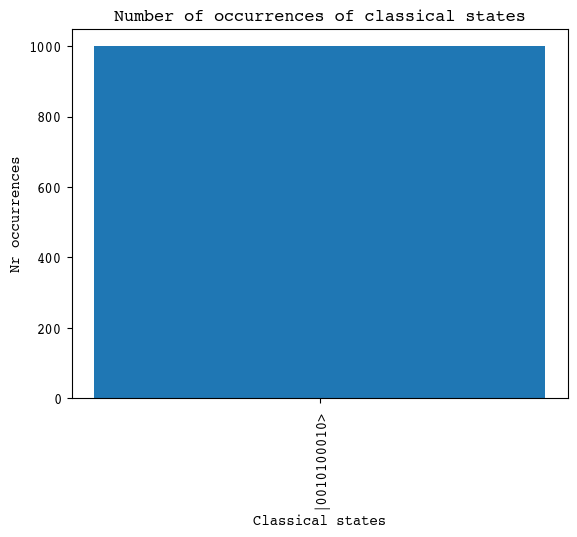

The most occurring result is '|0010100010>' with 1000 occurrences.
Binary strings start with least significant bit
Input integer value  a     = 2 has binary string 010
Input integer value  b     = 3 has binary string 110
Output integer value a + b = 5 has binary string 1010
Classical : sum of 2 and 3 is 5
Quantum   : sum of 2 and 3 is 5


In [13]:
a = 2
b = 3
c_classical = add_classical(a, b)
c_quantum = add_quantum(a, b, plot_histogram=True)
print(f"Classical : sum of {a} and {b} is {c_classical}")
print(f"Quantum   : sum of {a} and {b} is {c_quantum}")

Uncomment the code below to test the $3$-qubit adder for all possible $a$ and $b$, $0 \leq a, b \leq 7$.
Hence, $64$ cases are tested and the number of violations is counted.

In [14]:
# nr_violations = 0
# for a in range(8):
#     for b in range(8):
#         c_classical = add_classical(a, b)
#         c_quantum = add_quantum(a, b, plot_histogram=False)
#         if c_quantum != c_classical:
#             nr_violations = nr_violations + 1
# print(f"Number of violations is {nr_violations}")

The most occurring result is '|0000000000>' with 1000 occurrences.
Binary strings start with least significant bit
Input integer value  a     = 0 has binary string 000
Input integer value  b     = 0 has binary string 000
Output integer value a + b = 0 has binary string 0000
The most occurring result is '|0010000000>' with 1000 occurrences.
Binary strings start with least significant bit
Input integer value  a     = 0 has binary string 000
Input integer value  b     = 1 has binary string 100
Output integer value a + b = 1 has binary string 1000
The most occurring result is '|0000010000>' with 1000 occurrences.
Binary strings start with least significant bit
Input integer value  a     = 0 has binary string 000
Input integer value  b     = 2 has binary string 010
Output integer value a + b = 2 has binary string 0100
The most occurring result is '|0010010000>' with 1000 occurrences.
Binary strings start with least significant bit
Input integer value  a     = 0 has binary string 000
Input i